# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- контролировать добросовестность кассиров при продаже алкоголя.

**Цель**

Построить модель, которая по фотографии определит приблизительный возраст человека, используя набор фотографий людей с указанием возраста.

**Задачи**

В рамках работы предстоит:

- провести исследовательский анализ данных, чтобы выявить аномалии, выбросы, пропуски и т.д.

- выбрать подходящую нейросетевую модель и обучить её

- подобрать параметры модели, чтобы MAE на тестовой выборке не превышала 8 (желательно 7).

- проанализировать результаты и дать рекомендации для заказчика

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

## Исследовательский анализ данных

In [1]:
path_base = ''
path_img = path_base + 'final_files/'

In [4]:
faces_info = pd.read_csv(path_base + 'labels.csv')
faces_info.info()
faces_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


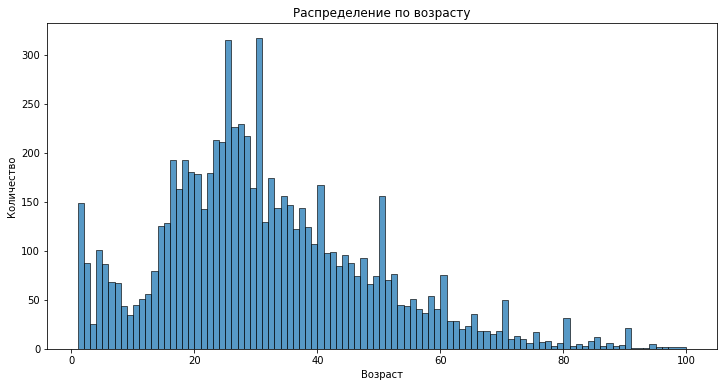

In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(
    faces_info, 
    legend=False, 
    bins=np.sort(faces_info.real_age.unique())
)
plt.title('Распределение по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Примерно 7500 образцов, наибольшее количество людей 20-30 лет, длинный хвост справа + довольно много совсем детских фото.

Посмотрим на первые 15.

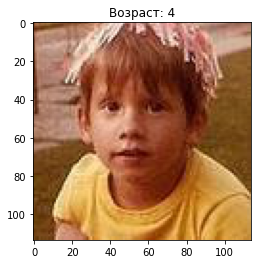

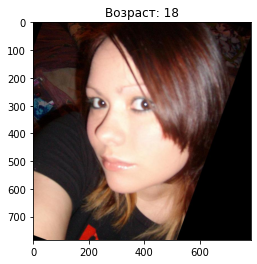

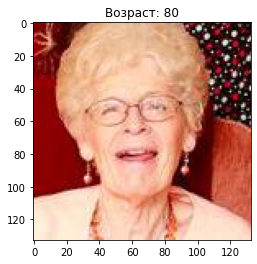

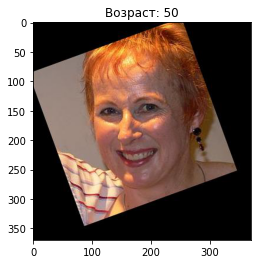

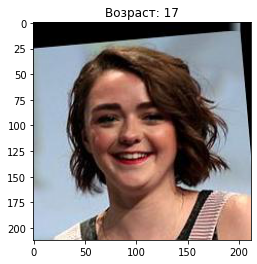

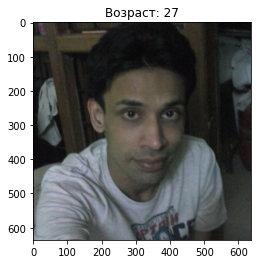

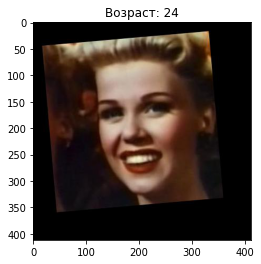

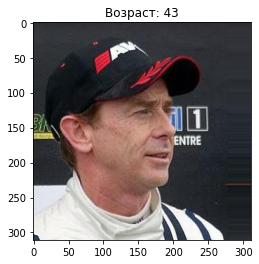

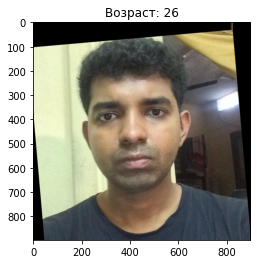

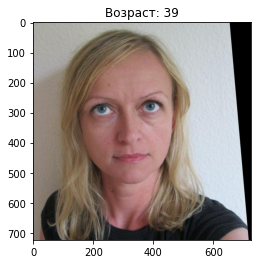

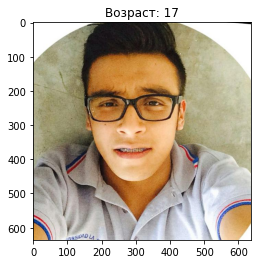

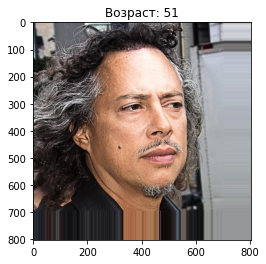

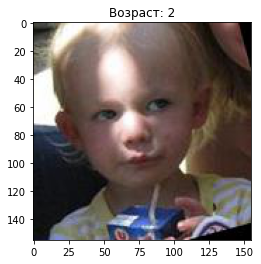

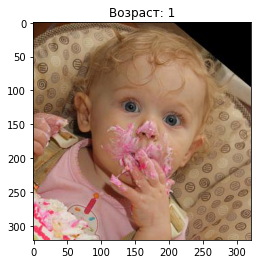

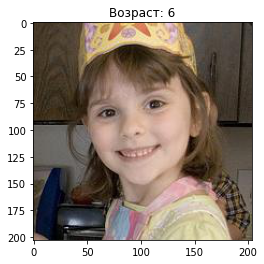

In [5]:
for i in range(15):
    fname = faces_info.file_name[i]
    img = Image.open(path_img + fname)
    plt.imshow(np.array(img))
    plt.title(f'Возраст: {faces_info.real_age[i]}')
    plt.show()

Мэйси Уильямс и Кирк Хэмметт)

Вроде бы всё в порядке - можно освоить flow_from_dataframe и попытаться обучить модель.


### Итог 
В качестве выводов сказал бы следующее:
 
- в данных пропусков и аномалий нет

- распределение по возрасту выглядит адекватным 

- разметка у фото также в порядке, если судить по первым 15

- уже у первых 15 есть разные разрешения - надо приводить к одному

- в остальном данные готовы для дальнейшей работы 


## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

### Код

```python
import numpy as np
import pandas as pd

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    
    data_gen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True
    )
    
    faces_info = pd.read_csv(path + 'labels.csv')
    path_img = path + 'final_files/'
    
    data_gen_flow = data_gen.flow_from_dataframe(
        faces_info,
        path_img,
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(224, 224),
        batch_size=32,
        seed=12345,
        subset='training'
    )
    
    return data_gen_flow


def load_test(path):
    
    data_gen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )
    
    faces_info = pd.read_csv(path + 'labels.csv')
    path_img = path + 'final_files/'
    
    data_gen_flow = data_gen.flow_from_dataframe(
        faces_info,
        path_img,
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(224, 224),
        batch_size=32,
        seed=12345,
        subset='validation'
    )
    
    return data_gen_flow


def create_model(input_shape):
    
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
        include_top=False
    )
    
    model = Sequential()
    optimizer = Adam(lr=0.0005)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data, 
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True
    )

    return model

```

### Выдача

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 47s - loss: 189.2141 - mae: 10.1126 - val_loss: 382.5620 - val_mae: 14.6225
Epoch 2/10
178/178 - 38s - loss: 111.2354 - mae: 7.9420 - val_loss: 391.8134 - val_mae: 14.8180
Epoch 3/10
178/178 - 38s - loss: 92.6047 - mae: 7.2994 - val_loss: 385.4177 - val_mae: 14.6355
Epoch 4/10
178/178 - 38s - loss: 72.5982 - mae: 6.4505 - val_loss: 192.4374 - val_mae: 10.3724
Epoch 5/10
178/178 - 38s - loss: 57.2965 - mae: 5.7900 - val_loss: 98.7506 - val_mae: 7.4374
Epoch 6/10
178/178 - 38s - loss: 45.1363 - mae: 5.1539 - val_loss: 123.9462 - val_mae: 8.2985
Epoch 7/10
178/178 - 38s - loss: 37.4642 - mae: 4.7401 - val_loss: 89.4363 - val_mae: 7.2679
Epoch 8/10
178/178 - 38s - loss: 32.3897 - mae: 4.3650 - val_loss: 86.2963 - val_mae: 7.1936
Epoch 9/10
178/178 - 38s - loss: 27.0895 - mae: 3.9810 - val_loss: 106.3742 - val_mae: 8.0973
Epoch 10/10
178/178 - 40s - loss: 23.7616 - mae: 3.7538 - val_loss: 85.4479 - val_mae: 6.8395
60/60 - 10s - loss: 85.4479 - mae: 6.8395
```

## Анализ обученной модели

В использованном наборе фото около 7500 человек. 
Выборка была поделена в соотношении 3:1 на обучающую и тестовую + изображения были приведены к разрешению 150х150. 
Для предсказания возраста была обучена ResNet50, у которой выход был заменён на один нейрон с выпрямленной линейной активацией.
В качестве старта были взяты веса, лежащие на сервере GPU-тренажёра (вероятно, это ImageNet).
Так как изображений много, в процедуре обучения фитовались все веса, а не только выход.
В качестве функции потерь была использована MSE, а для оценки качества - MAE.
На обучающей MAE составила 2.2 года, а на тестовой - 6.6, то есть модель немного переобучилась.
Однако, целевые MAE=7 на тестовой достигнуты.

С учётом точности модели закачику рекомендуется:

- делить покупателей на группы достаточно большие группы (не меньше 10-12 лет) 
- у всех, кого модель определит моложе 25, требовать документы при покупке соответствующих товаров